In [1]:
from imports import *

In [31]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('max_colwidth', 800)

In [19]:
data_dict = pd.read_html('data/Attribute+Descriptions.html')

data_dict = data_dict[0]

In [27]:
data_dict

,Field Name,Category,Description
0,FileNo,Identifier,North Dakota specific identifier for the well
1,CountyName,Location,Name of the County where the well is located
2,CurrentOperator,NaN,Name of the Company that operates the well
3,CurrentWellName,NaN,"Name of the well; essentially free text, naming conventions vary by operator"
4,DFElev,NaN,Drilling floor elevation
5,FieldName,Location,Name of the Field where this well is located
6,Footages,NaN,Description of where the well pad is located in relation to the drilling spacing unit
7,GRElev,NaN,Graded elevation
8,KBElev,NaN,Kelly Bushing elevation
9,LeaseName,Location,Name of the Lease associated with this well


In [2]:
%%time

%matplotlib inline

from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd
import re

from IPython.display import display

# Load the dataframes
test_df = pd.read_csv('data/cleaned-input.test.tsv', sep='\t', low_memory=False)
training_df = pd.read_csv('data/cleaned-input.training.tsv', sep='\t', low_memory=False)

TREE_COUNT = 20
MAX_DEPTH = 20
TARGET = 'production_liquid_90'
ID_COL = 'api'

CPU times: user 118 ms, sys: 15.7 ms, total: 134 ms
Wall time: 139 ms


In [9]:
%%time

# Drop blacklisted columns

BLACKLIST_PATTERNS = ['^recent_ipt_', '^production_', 'total_num_stages', 'bakken_isopach_ft']

drops = {}
blacklisted_columns = []
for pattern in BLACKLIST_PATTERNS:
    for column in training_df.columns:
        if column == TARGET:
            continue
            
        if re.match(pattern, column):
            if not pattern in drops:
                drops[pattern] = []
            drops[pattern].append(column)
            blacklisted_columns.append(column)
            
            test_df.drop(column, inplace=True, axis=1)
            training_df.drop(column, inplace=True, axis=1)

print(len(training_df), len(test_df))
print("Blacklisted columns: {}".format(blacklisted_columns))

(6529, 1586)
Blacklisted columns: []
CPU times: user 12.1 ms, sys: 5.94 ms, total: 18.1 ms
Wall time: 13.6 ms


In [4]:
%%time

# Drop cardinality == 0, cardinality == 1, cardinality == n, or (type='categorical and cardinality > 0.2 * n)

df = pd.concat([training_df, test_df])

for col in df.columns:
    if df[col].count() == 0:
        # drop cardinality = 0 (empty columns)
        df.drop(col, inplace=True, axis=1)
        print('Dropped {} since it was empty'.format(col))
    
    elif df[col].count() == 1:
        # drop cardinality = 1
        df.drop(col, inplace=True, axis=1)
        print('Dropped {} since it was always the same'.format(col))
        
    elif df[col].count() == df[col].value_counts().idxmax():
        # drop cardinality == count
        df.drop(col, inplace=True, axis=1)
        print('Dropped {} since it was always unique'.format(col))
        
    elif col != ID_COL and df[col].dtype == 'object' and len(df[col].value_counts()) > len(df) * 0.2:
        df.drop(col, inplace=True, axis=1)
        print('Dropped {} since it was categorical and had a high cardinality'.format(col))
        

# one-hot encode non-numeric fields
for col in df.columns:
    if col != ID_COL and df[col].dtype == 'object':
        dummies = pd.get_dummies(df[col], prefix=col, prefix_sep='=')
        df.drop(col, inplace=True, axis=1)
        df[dummies.columns] = dummies
        
# Impute median value for any missing fields
for col in df.columns:
    if len(df) - df[col].count() > 0:
        median = df[col].median()
        df[col].fillna(median, inplace=True)

Dropped CurrentWellName since it was categorical and had a high cardinality
Dropped Footages since it was categorical and had a high cardinality
Dropped LeaseName since it was categorical and had a high cardinality
Dropped LeaseNumber since it was categorical and had a high cardinality
Dropped OriginalWellName since it was categorical and had a high cardinality
Dropped spud_date since it was categorical and had a high cardinality
Dropped well_status_date since it was categorical and had a high cardinality
CPU times: user 981 ms, sys: 158 ms, total: 1.14 s
Wall time: 1.16 s


In [7]:
%%time

# Unmerge test and training set
test_apis = set(test_df['api'].values)
def get_data_group(row):
    if row['api'] in test_apis:
        return 'test'
    return 'training'
        
df['data_group'] = df.apply(get_data_group, axis=1)

training_df = df[df['data_group'] == 'training'].copy()
test_df = df[df['data_group'] == 'test'].copy()        

print(len(training_df), len(test_df))

test_df.drop('data_group', inplace=True, axis=1)
training_df.drop('data_group', inplace=True, axis=1)

(6529, 1586)
CPU times: user 659 ms, sys: 117 ms, total: 776 ms
Wall time: 806 ms


In [10]:
%%time

# split training and test set into input and target

training_y = training_df[[TARGET]].copy()
training_df.drop(TARGET, inplace=True, axis=1)

test_y = test_df[[TARGET]].copy()
test_df.drop(TARGET, inplace=True, axis=1)

CPU times: user 10.7 ms, sys: 6.13 ms, total: 16.8 ms
Wall time: 16.3 ms


In [11]:
%%time

# build model and print test set scores

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

model = ExtraTreesRegressor(n_estimators=TREE_COUNT, max_depth=MAX_DEPTH)

model.fit(training_df.drop('api', axis=1), training_y[TARGET].values)

test_predictions = model.predict(test_df.drop('api', axis=1))

training_target_mean = training_y.mean().values
naive_predictions = []
for _ in range(len(test_y)):
    naive_predictions.append(training_target_mean)
    
training_mean_mse = mean_squared_error(test_y, naive_predictions)
training_mean_rmse = math.sqrt(training_mean_mse)    

mse = mean_squared_error(test_y, test_predictions)
mae = mean_absolute_error(test_y, test_predictions)
rmse = math.sqrt(mse)
rrse = rmse / training_mean_rmse * 100

print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)
print("RRSE:", rrse)

('MSE:', 160163135.69689441)
('MAE:', 9132.8915803166474)
('RMSE:', 12655.55750241349)
('RRSE:', 63.318911588651346)
CPU times: user 6.49 s, sys: 124 ms, total: 6.61 s
Wall time: 6.71 s


In [17]:
model.score(test_df.drop("api", axis=1), test_y[TARGET].values)

0.5990004177103907

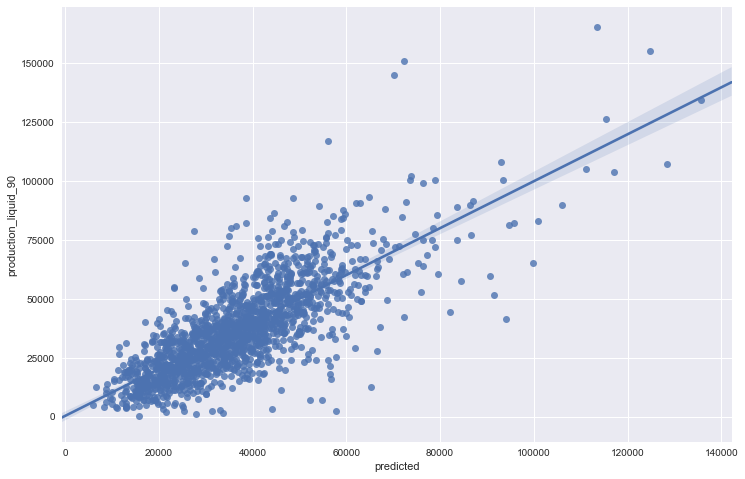

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

test_y['predicted'] = test_predictions

test_y

sns.regplot(x="predicted", y="production_liquid_90", data=test_y)

In [13]:
test_df

,FileNo,DFElev,GRElev,KBElev,Section,TD,api,bh_lat,bh_lng,legs,...,stimulated_formation=tyler,type_treatment=acid,"type_treatment=acid,gelled acid",type_treatment=fracture,"type_treatment=fracture,sand frac",type_treatment=hydrochloric acid,"type_treatment=hydrochloric acid,sand frac",type_treatment=other,"type_treatment=other,sand frac",type_treatment=sand frac
0,25893,2452.5,2149.0,2174.0,30,18541.0,US33023010680000,48.731764,-103.845153,3.0,...,0,0,0,0,0,0,0,0,0,1
1,21629,2452.5,2324.0,2354.0,27,18810.0,US33061019000000,48.136892,-102.332644,2.0,...,0,0,0,0,0,0,0,0,0,1
2,26027,2452.5,2334.0,2359.0,29,20805.0,US33053051430000,47.674747,-102.871779,2.0,...,0,0,0,0,0,0,0,0,0,1
3,24163,2452.5,2424.0,2450.0,33,20845.0,US33053045070000,47.702324,-102.708901,2.0,...,0,0,0,0,0,0,0,0,0,1
4,24902,2452.5,2213.0,2241.0,17,21040.0,US33053047660000,47.723891,-103.251070,3.0,...,0,0,0,0,0,0,0,0,0,1
5,25542,2452.5,2422.0,2448.0,16,14273.0,US33053049720000,47.980693,-102.964882,2.0,...,0,0,0,0,0,0,0,0,0,1
6,22550,2452.5,1940.0,1966.0,3,19910.0,US33061020550000,48.169072,-102.760164,2.0,...,0,0,0,0,0,0,0,0,0,1
7,25311,2452.5,2352.0,2378.0,8,21442.0,US33061025000000,48.167213,-102.670654,3.0,...,0,0,0,0,0,0,0,0,0,1
8,25571,2452.5,2060.0,2085.0,12,21090.0,US33053049810000,48.053851,-103.608733,2.0,...,0,0,0,0,0,0,0,0,0,1
9,21202,2452.5,2325.0,2343.0,21,19584.0,US33105023020000,48.588402,-103.346976,3.0,...,0,0,0,0,0,0,0,0,0,1
